# Predicting wild fires in California based on Environmental Conditions 🌲🔥

Dataset used: https://www.openml.org/search?type=data&status=active&id=43606

### 1. Importing dependencies

In [33]:
import pandas as pd
import arff
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### 2. Visualizing data

Loading data:

In [2]:
# Load ARFF file
with open("./california-environmental-conditions-dataset.arff") as f:
    data = arff.load(f)

# Define data types for each column
dtype_dict = {
    'Stn_Id': 'int64',
    'Stn_Name': 'str',
    'CIMIS_Region': 'str',
    'Date': 'str',
    'ETo_(in)': 'float64',
    'Precip_(in)': 'float64',
    'Sol_Rad_(Ly/day)': 'float64',
    'Avg_Vap_Pres_(mBars)': 'float64',
    'Max_Air_Temp_(F)': 'float64',
    'Min_Air_Temp_(F)': 'float64',
    'Avg_Air_Temp_(F)': 'float64',
    'Max_Rel_Hum_(%)': 'float64',
    'Min_Rel_Hum_(%)': 'float64',
    'Avg_Rel_Hum_(%)': 'float64',
    'Dew_Point_(F)': 'float64',
    'Avg_Wind_Speed_(mph)': 'float64',
    'Wind_Run_(miles)': 'float64',
    'Avg_Soil_Temp_(F)': 'float64',
    'Target': 'int64'
}

# Creating DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

# Setting dtypes
for col, dtype in dtype_dict.items():
    df[col] = df[col].astype(dtype)

# Getting dataset
print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Data loaded successfully: 128125 rows, 19 columns


,Stn_Id,Stn_Name,CIMIS_Region,Date,ETo_(in),Precip_(in),Sol_Rad_(Ly/day),Avg_Vap_Pres_(mBars),Max_Air_Temp_(F),Min_Air_Temp_(F),Avg_Air_Temp_(F),Max_Rel_Hum_(%),Min_Rel_Hum_(%),Avg_Rel_Hum_(%),Dew_Point_(F),Avg_Wind_Speed_(mph),Wind_Run_(miles),Avg_Soil_Temp_(F),Target
0,2,FivePoints,San Joaquin Valley,1/1/2018,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0
1,2,FivePoints,San Joaquin Valley,1/2/2018,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0
2,2,FivePoints,San Joaquin Valley,1/3/2018,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0
3,2,FivePoints,San Joaquin Valley,1/4/2018,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0
4,2,FivePoints,San Joaquin Valley,1/5/2018,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0


Data insights/visualization:

In [3]:
# Human-readable descriptions based on dataset metadata
description_map = {
    'Target': 'Binary target indicating whether a fire occurred (0 = no, 1 = yes)',

    'Stn_Id': 'CIMIS station ID (numeric identifier for weather station)',
    'Stn_Name': 'Weather station name',
    'CIMIS_Region': 'CIMIS region name',

    'Date': 'Observation date (MM/DD/YYYY)',

    'ETo_(in)': 'Reference evapotranspiration in inches',
    'Precip_(in)': 'Precipitation in inches',

    'Sol_Rad_(Ly/day)': 'Solar radiation (Ly/day)',

    'Avg_Vap_Pres_(mBars)': 'Average vapor pressure in mBars',

    'Max_Air_Temp_(F)': 'Maximum air temperature (°F)',
    'Min_Air_Temp_(F)': 'Minimum air temperature (°F)',
    'Avg_Air_Temp_(F)': 'Average air temperature (°F)',

    'Max_Rel_Hum_(%)': 'Maximum relative humidity (%)',
    'Min_Rel_Hum_(%)': 'Minimum relative humidity (%)',
    'Avg_Rel_Hum_(%)': 'Average relative humidity (%)',

    'Dew_Point_(F)': 'Dew point temperature (°F)',
    'Avg_Wind_Speed_(mph)': 'Average wind speed (mph)',
    'Wind_Run_(miles)': 'Wind run (miles) — cumulative distance traveled by wind',

    'Avg_Soil_Temp_(F)': 'Average soil temperature (°F)'
}

summary = []
for col in df.columns:

    # Getting col
    col_series = df[col]

    # Getting col properties
    dtype = str(col_series.dtype)
    distinct = int(col_series.nunique(dropna=True))
    missing = int(col_series.isnull().sum())

    # Showing examples
    examples = list(pd.Series(col_series.dropna().unique()).astype(str)[:3])
    examples_str = "<><>".join(examples) if examples else ""
    description = description_map.get(col, "NO DESCRIPTION FOUND")

    # Building the list
    summary.append({
        'column': col,
        'dtype': dtype,
        'distinct_values': distinct,
        'missing': missing,
        'examples': examples_str,
        'description': description
    })

# Converting list to DataFrame
summary_df = pd.DataFrame(summary)

# Numeric columns
numeric_cols = df.select_dtypes(include=['number'])
numeric_cols_list = numeric_cols.columns.tolist()
print(f"Numeric columns ({len(numeric_cols_list)}): {numeric_cols_list}")

# Non-numeric columns  
non_numeric_cols = df.select_dtypes(exclude=['number'])
non_numeric_cols_list = non_numeric_cols.columns.tolist()
print(f"Non-numeric columns ({len(non_numeric_cols_list)}): {non_numeric_cols_list}")

# Displaying DataFrame
summary_df

Numeric columns (16): ['Stn_Id', 'ETo_(in)', 'Precip_(in)', 'Sol_Rad_(Ly/day)', 'Avg_Vap_Pres_(mBars)', 'Max_Air_Temp_(F)', 'Min_Air_Temp_(F)', 'Avg_Air_Temp_(F)', 'Max_Rel_Hum_(%)', 'Min_Rel_Hum_(%)', 'Avg_Rel_Hum_(%)', 'Dew_Point_(F)', 'Avg_Wind_Speed_(mph)', 'Wind_Run_(miles)', 'Avg_Soil_Temp_(F)', 'Target']
Non-numeric columns (3): ['Stn_Name', 'CIMIS_Region', 'Date']


,column,dtype,distinct_values,missing,examples,description
0,Stn_Id,int64,153,0,2<><>5<><>6,CIMIS station ID (numeric identifier for weath...
1,Stn_Name,object,153,0,FivePoints<><>Shafter<><>Davis,Weather station name
2,CIMIS_Region,object,14,0,San Joaquin Valley<><>Sacramento Valley<><>Sie...,CIMIS region name
3,Date,object,991,0,1/1/2018<><>1/2/2018<><>1/3/2018,Observation date (MM/DD/YYYY)
4,ETo_(in),float64,50,83,0.06<><>0.04<><>0.07,Reference evapotranspiration in inches
5,Precip_(in),float64,312,0,0.0<><>0.01<><>0.04,Precipitation in inches
6,Sol_Rad_(Ly/day),float64,976,0,219.0<><>127.0<><>125.0,Solar radiation (Ly/day)
7,Avg_Vap_Pres_(mBars),float64,333,0,7.3<><>7.4<><>8.4,Average vapor pressure in mBars
8,Max_Air_Temp_(F),float64,922,3,63.4<><>59.8<><>61.1,Maximum air temperature (°F)
9,Min_Air_Temp_(F),float64,884,1,35.3<><>37.7<><>37.3,Minimum air temperature (°F)


In [4]:
df.describe()

,Stn_Id,ETo_(in),Precip_(in),Sol_Rad_(Ly/day),Avg_Vap_Pres_(mBars),Max_Air_Temp_(F),Min_Air_Temp_(F),Avg_Air_Temp_(F),Max_Rel_Hum_(%),Min_Rel_Hum_(%),Avg_Rel_Hum_(%),Dew_Point_(F),Avg_Wind_Speed_(mph),Wind_Run_(miles),Avg_Soil_Temp_(F),Target
count,128125.000000,128042.000000,128125.000000,128125.000000,128125.000000,128122.000000,128124.000000,128120.000000,128125.000000,128125.000000,128112.000000,128112.000000,128125.000000,128125.000000,128105.000000,128125.000000
mean,157.257686,0.157898,0.038263,458.957136,11.285094,75.279722,48.495665,61.185965,85.018100,40.166431,61.374438,45.939090,4.314043,103.532969,62.799889,0.041787
std,72.576703,0.086695,0.202978,198.349566,4.105851,14.742913,11.430017,12.386885,16.407883,20.678380,20.273168,10.927562,2.041915,48.999902,10.672439,0.200104
min,2.000000,0.000000,0.000000,0.000000,0.000000,24.900000,-5.000000,13.000000,0.000000,0.000000,0.000000,-74.300000,0.700000,16.200000,31.500000,0.000000
25%,99.000000,0.080000,0.000000,301.000000,8.400000,64.000000,41.100000,52.800000,78.000000,23.000000,46.000000,40.000000,3.000000,71.600000,54.400000,0.000000
50%,171.000000,0.150000,0.000000,471.000000,11.200000,74.300000,48.800000,60.100000,91.000000,37.000000,63.000000,47.500000,3.800000,92.300000,62.900000,0.000000
75%,219.000000,0.230000,0.000000,633.000000,14.000000,86.100000,55.800000,69.200000,97.000000,55.000000,78.000000,53.600000,5.100000,122.400000,70.800000,0.000000
max,262.000000,0.490000,13.610000,6618.000000,39.700000,123.700000,93.400000,106.500000,100.000000,100.000000,100.000000,82.200000,46.900000,1125.300000,96.900000,1.000000


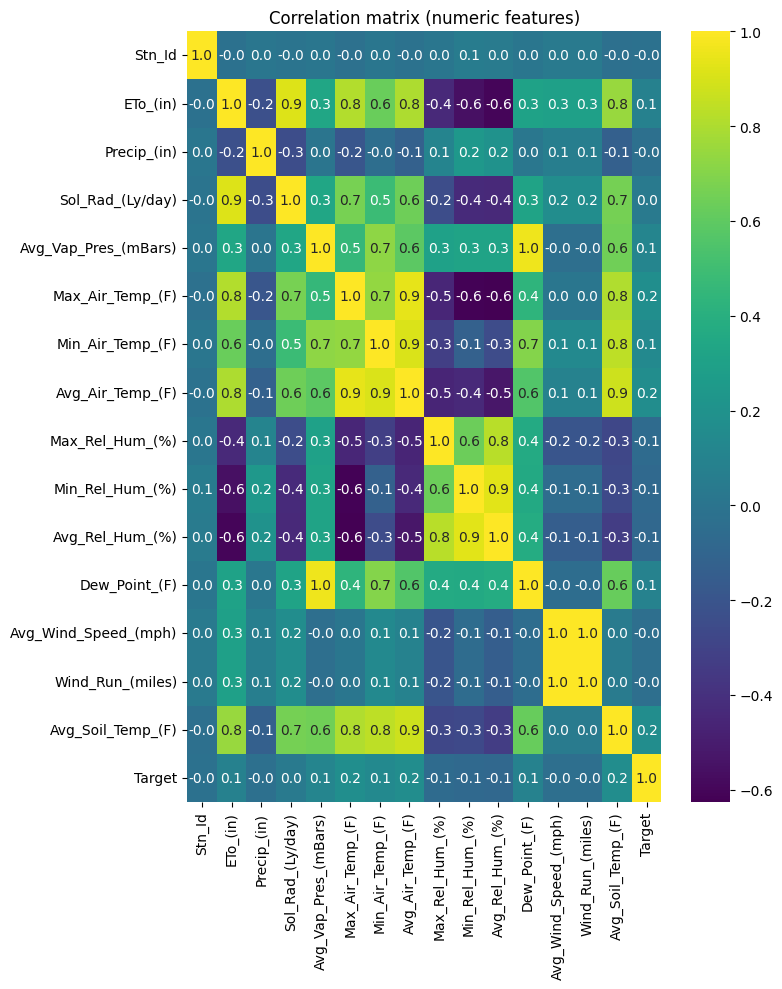

In [5]:
# Compute correlation
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(8, 10))
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.1f')
plt.title('Correlation matrix (numeric features)')
plt.tight_layout()
plt.show()

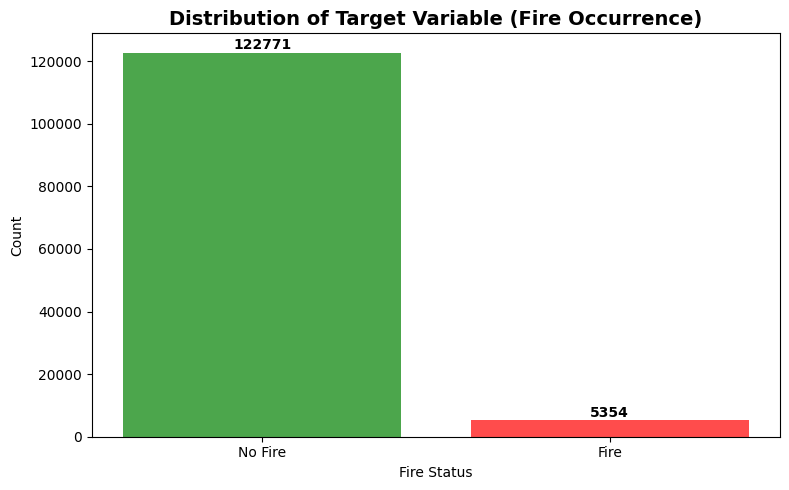

No Fire (0): 122771 (95.82%)
Fire (1): 5354 (4.18%)


In [6]:
# Distribution of target variable
plt.figure(figsize=(8, 5))
target_counts = df["Target"].value_counts()
plt.bar(['No Fire', 'Fire'], target_counts.values, color=['green', 'red'], alpha=0.7)
plt.title('Distribution of Target Variable (Fire Occurrence)', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Fire Status')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 1000, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"No Fire (0): {target_counts[0]} ({target_counts[0]/len(df["Target"])*100:.2f}%)")
print(f"Fire (1): {target_counts[1]} ({target_counts[1]/len(df["Target"])*100:.2f}%)")

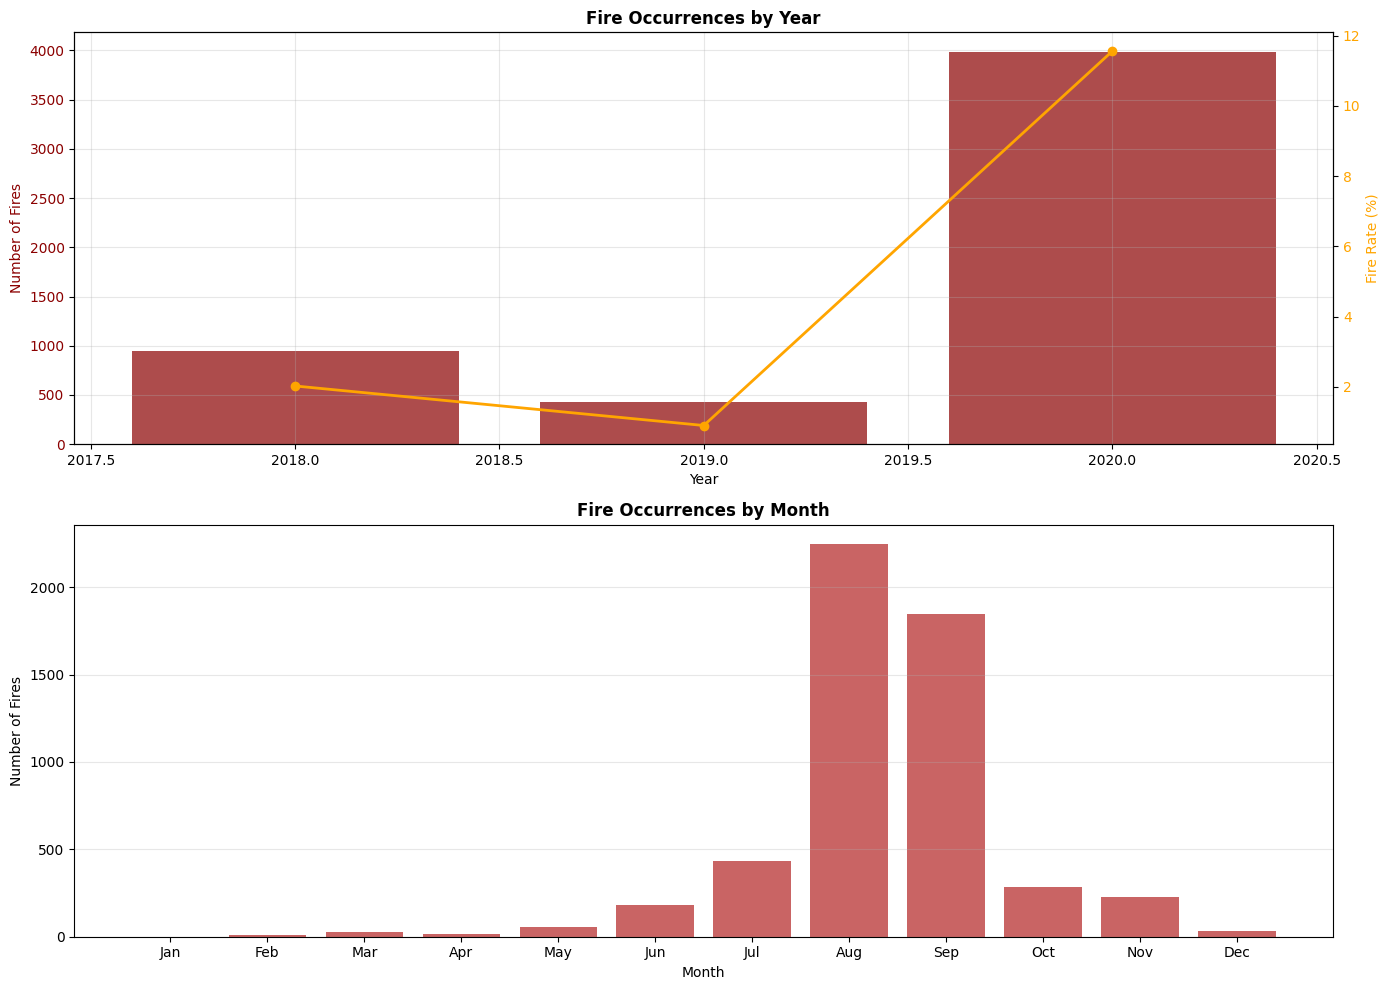

In [7]:
# Time series: Convert date and analyze temporal patterns
df['Date_parsed'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Year'] = df['Date_parsed'].dt.year
df['Month'] = df['Date_parsed'].dt.month

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Fire occurrences by year
yearly_fires = df.groupby('Year')['Target'].agg(['sum', 'count'])
yearly_fires['fire_rate'] = (yearly_fires['sum'] / yearly_fires['count'] * 100)

axes[0].bar(yearly_fires.index, yearly_fires['sum'], color='darkred', alpha=0.7, label='Fire Count')
ax2 = axes[0].twinx()
ax2.plot(yearly_fires.index, yearly_fires['fire_rate'], color='orange', marker='o', linewidth=2, label='Fire Rate (%)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Fires', color='darkred')
ax2.set_ylabel('Fire Rate (%)', color='orange')
axes[0].set_title('Fire Occurrences by Year', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='orange')
axes[0].grid(alpha=0.3)

# Fire occurrences by month
monthly_fires = df.groupby('Month')['Target'].agg(['sum', 'count'])
monthly_fires['fire_rate'] = (monthly_fires['sum'] / monthly_fires['count'] * 100)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axes[1].bar(range(1, 13), monthly_fires['sum'], color='firebrick', alpha=0.7)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Fires')
axes[1].set_title('Fire Occurrences by Month', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

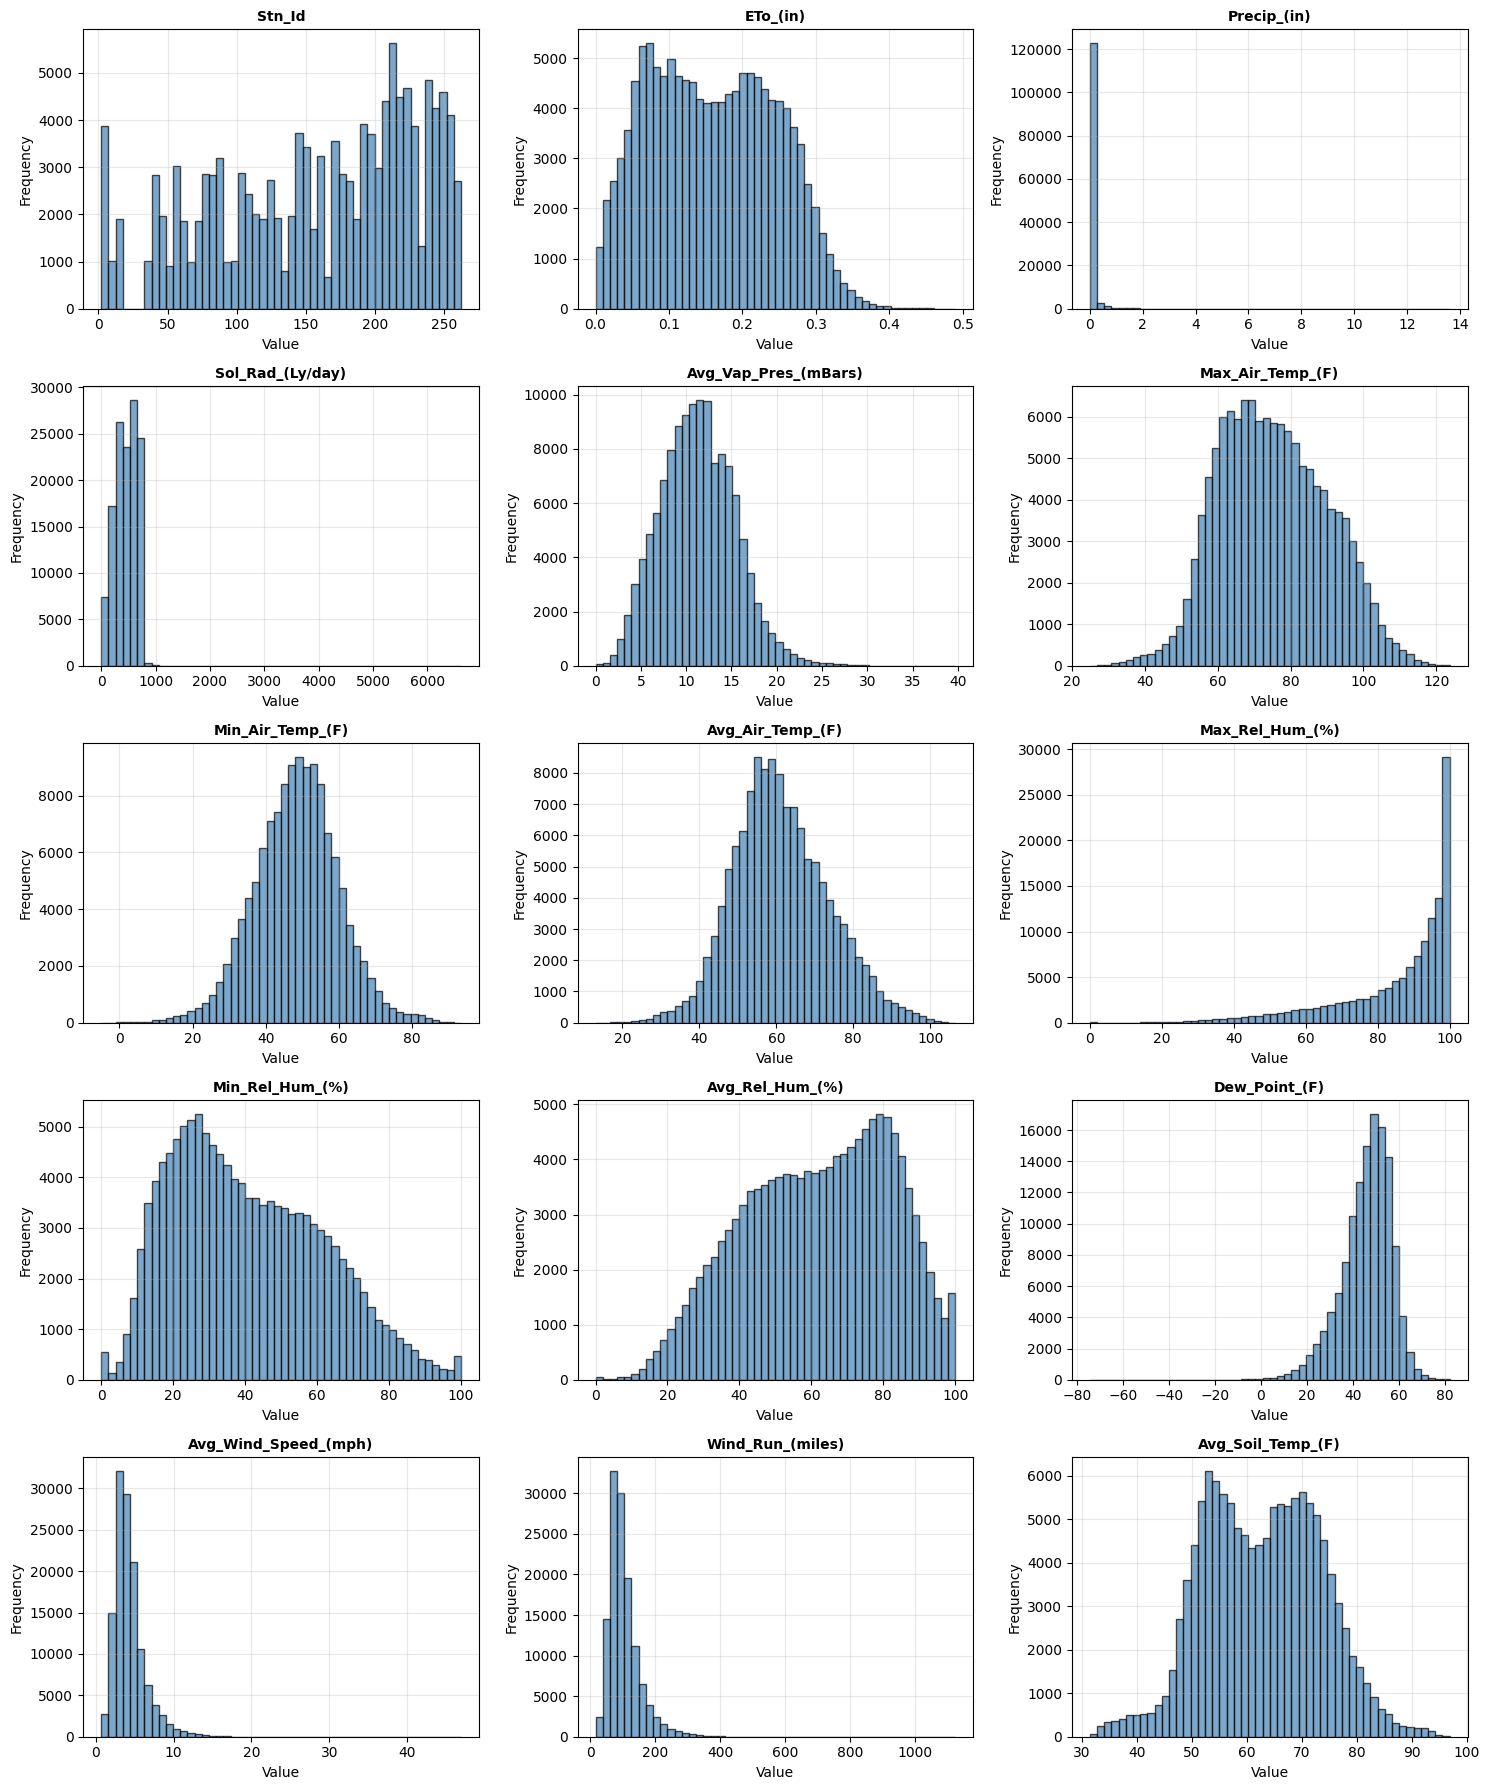

In [8]:
# Distribution of numeric features
fig, axes = plt.subplots(5, 3, figsize=(15, 18))
axes = axes.ravel()

# Exclude 'Target' from features to plot since we're grouping by Target
numeric_features = [col for col in numeric_cols.columns.tolist() if col != 'Target']

for idx, col in enumerate(numeric_features):
    axes[idx].hist(df[col].dropna(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Find features with high correlation (> 0.5 or < -0.5)
# Get correlation matrix
corr_matrix = numeric_cols.corr()

# Find pairs with high correlation (excluding diagonal)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

# Display high correlation pairs
high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)
print(f"Found {len(high_corr_df)} feature pairs with |correlation| > 0.5:\n")
high_corr_df

Found 30 feature pairs with |correlation| > 0.5:



,feature1,feature2,correlation
29,Avg_Wind_Speed_(mph),Wind_Run_(miles),0.999900
12,Avg_Vap_Pres_(mBars),Dew_Point_(F),0.958162
15,Max_Air_Temp_(F),Avg_Air_Temp_(F),0.939359
27,Min_Rel_Hum_(%),Avg_Rel_Hum_(%),0.926691
0,ETo_(in),Sol_Rad_(Ly/day),0.912283
19,Min_Air_Temp_(F),Avg_Air_Temp_(F),0.905173
24,Avg_Air_Temp_(F),Avg_Soil_Temp_(F),0.875567
21,Min_Air_Temp_(F),Avg_Soil_Temp_(F),0.840396
26,Max_Rel_Hum_(%),Avg_Rel_Hum_(%),0.827034
1,ETo_(in),Max_Air_Temp_(F),0.814440


### 3. Data cleaning:

In [10]:
df.dropna(inplace=True)
df.isnull().sum()

Stn_Id                  0
Stn_Name                0
CIMIS_Region            0
Date                    0
ETo_(in)                0
Precip_(in)             0
Sol_Rad_(Ly/day)        0
Avg_Vap_Pres_(mBars)    0
Max_Air_Temp_(F)        0
Min_Air_Temp_(F)        0
Avg_Air_Temp_(F)        0
Max_Rel_Hum_(%)         0
Min_Rel_Hum_(%)         0
Avg_Rel_Hum_(%)         0
Dew_Point_(F)           0
Avg_Wind_Speed_(mph)    0
Wind_Run_(miles)        0
Avg_Soil_Temp_(F)       0
Target                  0
Date_parsed             0
Year                    0
Month                   0
dtype: int64

In [11]:
# Removing unnecessary features
df.drop(columns="Stn_Name", inplace=True)

# Parsing date to date object
df['Date_parsed'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

### 4. Feature Engineering

In [12]:
# Sort by region, station and date to ensure proper time series calculations
df = df.sort_values(['CIMIS_Region', 'Stn_Id', 'Date_parsed']).reset_index(drop=True)

print("Creating rolling average features based on Date...")
print(f"Original dataframe shape: {df.shape}")

# Group by region and station for proper rolling calculations
grouped = df.groupby(['CIMIS_Region', 'Stn_Id'])

# ETo_(in) - previous day, 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [1, 3, 5, 7, 14, 21]:
    col_name = f'ETo_(in)_avg_{days}d'
    df[col_name] = grouped['ETo_(in)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Precip_(in) - previous day, 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [1, 3, 5, 7, 14, 21]:
    col_name = f'Precip_(in)_avg_{days}d'
    df[col_name] = grouped['Precip_(in)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Sol_Rad_(Ly/day) - previous day, 3 days, 5 days
for days in [1, 3, 5]:
    col_name = f'Sol_Rad_(Ly/day)_avg_{days}d'
    df[col_name] = grouped['Sol_Rad_(Ly/day)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Vap_Pres_(mBars) - previous day, 3 days, 5 days
for days in [1, 3, 5]:
    col_name = f'Avg_Vap_Pres_(mBars)_avg_{days}d'
    df[col_name] = grouped['Avg_Vap_Pres_(mBars)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Max_Air_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Max_Air_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Max_Air_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Min_Air_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Min_Air_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Min_Air_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Air_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Avg_Air_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Avg_Air_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Max_Rel_Hum_(%) - 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [3, 5, 7, 14, 21]:
    col_name = f'Max_Rel_Hum_(%)_avg_{days}d'
    df[col_name] = grouped['Max_Rel_Hum_(%)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Min_Rel_Hum_(%) - 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [3, 5, 7, 14, 21]:
    col_name = f'Min_Rel_Hum_(%)_avg_{days}d'
    df[col_name] = grouped['Min_Rel_Hum_(%)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Rel_Hum_(%) - 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [3, 5, 7, 14, 21]:
    col_name = f'Avg_Rel_Hum_(%)_avg_{days}d'
    df[col_name] = grouped['Avg_Rel_Hum_(%)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Soil_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Avg_Soil_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Avg_Soil_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

print(f"\nFinal dataframe shape: {df.shape}")
print(f"Total new features created: {df.shape[1] - 19}")  # 19 was the original number of columns

Creating rolling average features based on Date...
Original dataframe shape: (128009, 21)
Created: ETo_(in)_avg_1d
Created: ETo_(in)_avg_3d
Created: ETo_(in)_avg_5d
Created: ETo_(in)_avg_7d
Created: ETo_(in)_avg_14d
Created: ETo_(in)_avg_21d
Created: Precip_(in)_avg_1d
Created: Precip_(in)_avg_3d
Created: Precip_(in)_avg_5d
Created: Precip_(in)_avg_7d
Created: Precip_(in)_avg_14d
Created: Precip_(in)_avg_21d
Created: Sol_Rad_(Ly/day)_avg_1d
Created: Sol_Rad_(Ly/day)_avg_3d
Created: Sol_Rad_(Ly/day)_avg_5d
Created: Avg_Vap_Pres_(mBars)_avg_1d
Created: Avg_Vap_Pres_(mBars)_avg_3d
Created: Avg_Vap_Pres_(mBars)_avg_5d
Created: Max_Air_Temp_(F)_avg_3d
Created: Max_Air_Temp_(F)_avg_5d
Created: Precip_(in)_avg_21d
Created: Sol_Rad_(Ly/day)_avg_1d
Created: Sol_Rad_(Ly/day)_avg_3d
Created: Sol_Rad_(Ly/day)_avg_5d
Created: Avg_Vap_Pres_(mBars)_avg_1d
Created: Avg_Vap_Pres_(mBars)_avg_3d
Created: Avg_Vap_Pres_(mBars)_avg_5d
Created: Max_Air_Temp_(F)_avg_3d
Created: Max_Air_Temp_(F)_avg_5d
Created

In [13]:
# Show sample data with some new features
sample_cols = ['Date', 'CIMIS_Region', 'Stn_Id', 'ETo_(in)', 'ETo_(in)_avg_1d', 'ETo_(in)_avg_3d', 'ETo_(in)_avg_7d']
print(f"\nSample data with new features:")
df[sample_cols].head(10)


Sample data with new features:


,Date,CIMIS_Region,Stn_Id,ETo_(in),ETo_(in)_avg_1d,ETo_(in)_avg_3d,ETo_(in)_avg_7d
0,1/1/2018,Bishop,35,0.07,NaN,NaN,NaN
1,1/2/2018,Bishop,35,0.04,0.07,NaN,NaN
2,1/3/2018,Bishop,35,0.07,0.04,NaN,NaN
3,1/4/2018,Bishop,35,0.06,0.07,0.060000,NaN
4,1/5/2018,Bishop,35,0.06,0.06,0.056667,NaN
5,1/6/2018,Bishop,35,0.07,0.06,0.063333,NaN
6,1/7/2018,Bishop,35,0.07,0.07,0.063333,NaN
7,1/8/2018,Bishop,35,0.02,0.07,0.066667,0.062857
8,1/10/2018,Bishop,35,0.05,0.02,0.053333,0.055714
9,1/11/2018,Bishop,35,0.05,0.05,0.046667,0.057143


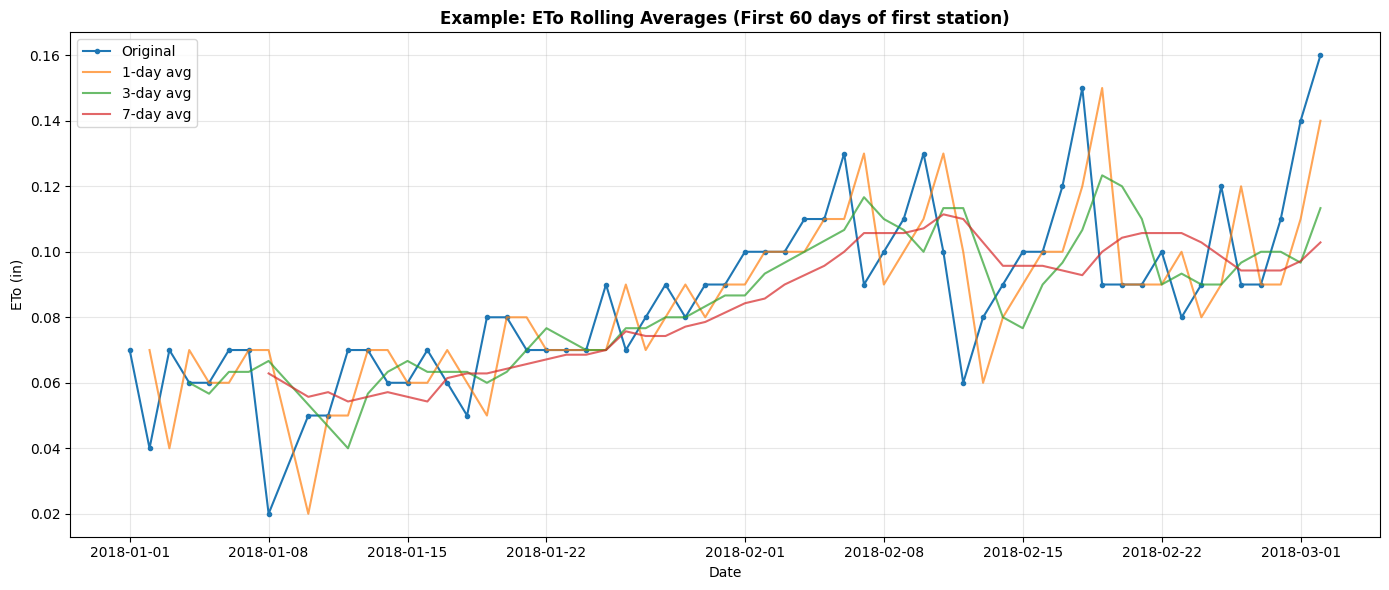

In [14]:
# Visualize one example: ETo rolling averages
plt.figure(figsize=(14, 6))

# Plot for a single station
station_sample = df[df['Stn_Id'] == df['Stn_Id'].iloc[0]].head(60)

plt.plot(station_sample['Date_parsed'], station_sample['ETo_(in)'],
        label='Original', marker='o', markersize=3)
plt.plot(station_sample['Date_parsed'], station_sample['ETo_(in)_avg_1d'],
        label='1-day avg', alpha=0.7)
plt.plot(station_sample['Date_parsed'], station_sample['ETo_(in)_avg_3d'],
        label='3-day avg', alpha=0.7)
plt.plot(station_sample['Date_parsed'], station_sample['ETo_(in)_avg_7d'],
        label='7-day avg', alpha=0.7)

# Get current axis and set labels
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('ETo (in)')
ax.set_title('Example: ETo Rolling Averages (First 60 days of first station)', fontweight='bold')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Getting first and last date after removing missing values
print("First date before removing missing values:", df["Date_parsed"].head(1).to_string(index=False))
print("Last date before removing missing values:", df["Date_parsed"].tail(1).to_string(index=False))
print("\nMissing values total:", df.isna().sum().sum())

First date before removing missing values: 2018-01-01
Last date before removing missing values: 2020-09-15

Missing values total: 43186


In [16]:
# UNDERSTAND WHY I AM DROPPING TIME SERIES AND THE DATE IS NOT CHANING, I AM DOING SOMETHING WRONG
df.dropna(inplace=True)

In [17]:
# Getting first and last date after removing missing values
print("First date after removing missing values:", df["Date_parsed"].head(1).to_string(index=False))
print("Last date after removing missing values:", df["Date_parsed"].tail(1).to_string(index=False))
print("\nMissing values total:", df.isna().sum().sum())

First date after removing missing values: 2018-01-23
Last date after removing missing values: 2020-09-15

Missing values total: 0

Missing values total: 0


In [18]:
# Converting "CIMIS_Region" to numbers using ordinal encoding
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(df[["CIMIS_Region"]])
df["CIMIS_Region_encoded"] = encoded  

print("Ordinal encoding applied to CIMIS_Region:")
for i, region in enumerate(encoder.categories_[0]):
    print(f"  {region}: {i}")
print(f"\nNew column 'CIMIS_Region_encoded' created with shape: {df['CIMIS_Region_encoded'].shape}")

Ordinal encoding applied to CIMIS_Region:
  Bishop: 0
  Central Coast Valleys: 1
  Eastern Sierra Basin  Range: 2
  Imperial/Coachella Valley: 3
  Los Angeles Basin: 4
  Monterey Bay: 5
  North Coast Valleys: 6
  Northeast Plateau: 7
  Sacramento Valley: 8
  San Bernardino: 9
  San Francisco Bay: 10
  San Joaquin Valley: 11
  Sierra Foothill: 12
  South Coast Valleys: 13

New column 'CIMIS_Region_encoded' created with shape: (125006,)


### 5. Data Analysis

In [19]:
# Separating data and dropping not useful columns
# Remove Target, date-related columns, and original CIMIS_Region (keep encoded version)
X = df.drop(columns=["Target", "Date", "Date_parsed", "Year", "Month", "CIMIS_Region"])
y = df["Target"]

# Verify all columns are numeric
print("All features are numeric ✅") if X.apply(pd.api.types.is_numeric_dtype).all() else print("Non-numeric featrures found ❌")

All features are numeric ✅


PCA analysis for dimensionality reduction, simplifying large datasets

In [20]:
# Ensuring each feature contributes equaly to the analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
pca = PCA()
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

# How many components explain 
num = np.argmax(cumulative >= 0.97) + 1
num

np.int64(16)

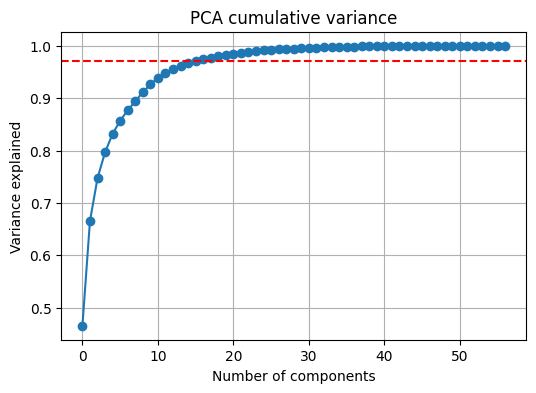

In [22]:
plt.figure(figsize=(6,4))
plt.plot(cumulative, marker='o')
plt.axhline(0.97, linestyle='--', color='red')
plt.title("PCA cumulative variance")
plt.ylabel("Variance explained")
plt.xlabel("Number of components")
plt.grid(True)
plt.show()


In [23]:
# Print key PCA results
print(f"Original number of features: {X.shape[1]}")
print(f"Components needed for 97% variance: {num}")

Original number of features: 57
Components needed for 97% variance: 16


Decision Tree Regression

In [24]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

dtc = DecisionTreeClassifier(max_depth=4, random_state=0)
dtc.fit(X_train, y_train)


Training set: 100004 samples
Test set: 25002 samples


,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


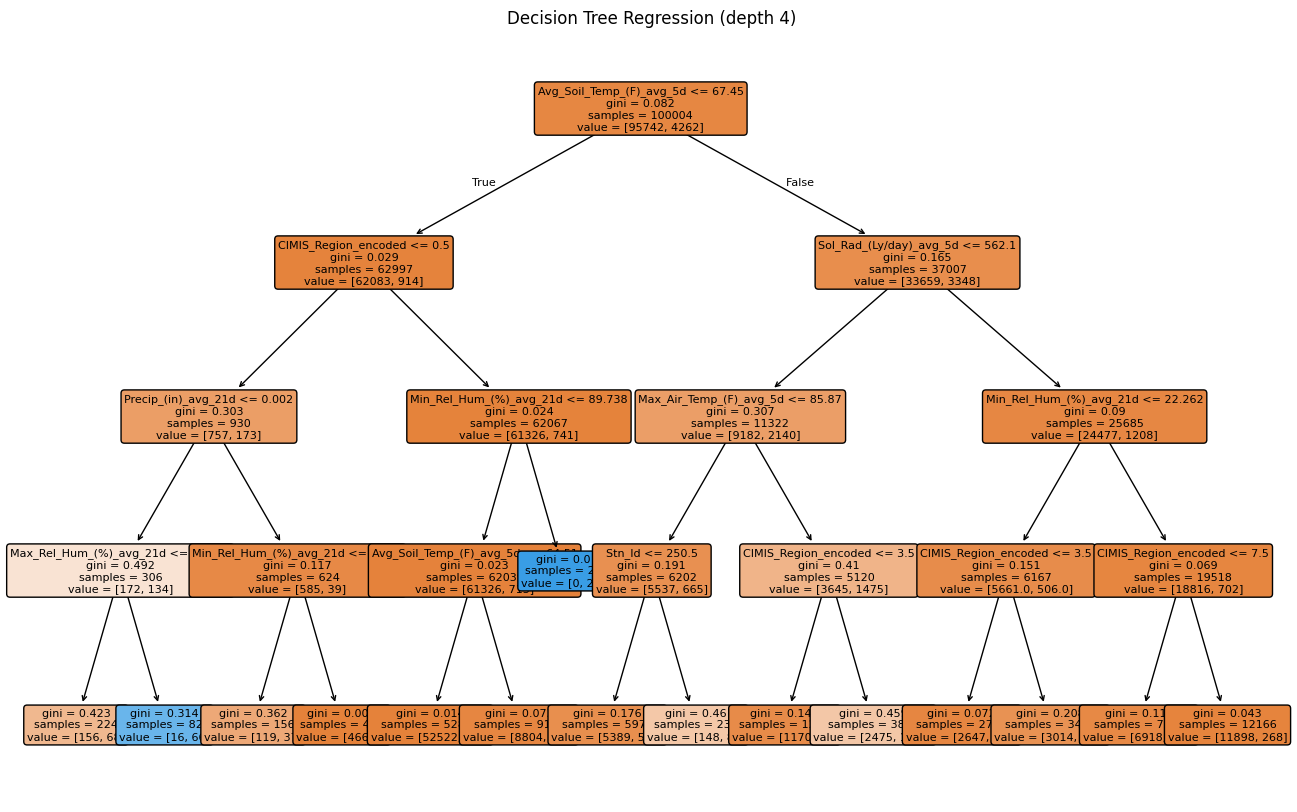

In [25]:
plt.figure(figsize=(16,10))
tree.plot_tree(dtc,
            feature_names=X.columns,
            filled=True,
            rounded=True,
            fontsize=8)
plt.title("Decision Tree Regression (depth 4)")
plt.show()

<b>PCA analysis:</b>
    If PC16 has 97% variance, it means more than half of all variability in the original data can be described using just this one new axis. In other words, 97% much of the data’s structure is captured with only 16 features.

<b>Decision Tree exploration:</b>
    Avg_Soil_Temp_(F) is the most predictive feature for the wild fires. Additionally, all the splits make intuitive sense.

### 6. Model training

In [26]:
# Cross validation amount
folds = 4

In [27]:
# Initialize results dictionary and scoring metrics
results = {}

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

print(f"Ready to train models with {folds}-fold cross-validation")

Ready to train models with 4-fold cross-validation


In [28]:
# Model 1: Random Forest
print("\n" + "="*80)
print("RANDOM FOREST")
print("="*80)

# Initialize model with hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=150,      # Reduced for efficiency while maintaining performance
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    max_depth=20,          # Limited to prevent overfitting
    min_samples_split=4,   # Increased to prevent overfitting on small samples
    min_samples_leaf=2,    # Ensures leaves have enough samples
    class_weight='balanced'  # Handle class imbalance
)

# Perform cross-validation
print(f"\nPerforming {folds}-fold cross-validation...")
cv_results = cross_validate(rf_model, X_train, y_train, cv=folds, scoring=scoring, n_jobs=-1)

# Store CV results
results['Random Forest'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")


RANDOM FOREST

Performing 4-fold cross-validation...

Cross-Validation Results:
  Accuracy:  0.9710 (+/- 0.0006)
  Precision: 0.6737 (+/- 0.0103)
  Recall:    0.6201 (+/- 0.0065)
  F1-Score:  0.6458 (+/- 0.0063)

Cross-Validation Results:
  Accuracy:  0.9710 (+/- 0.0006)
  Precision: 0.6737 (+/- 0.0103)
  Recall:    0.6201 (+/- 0.0065)
  F1-Score:  0.6458 (+/- 0.0063)


In [31]:
# Model 2: AdaBoost
print("\n" + "="*80)
print("ADABOOST")
print("="*80)

# Initialize model with hyperparameters
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Shallow trees as weak learners
    n_estimators=150,      # Increased for better performance
    random_state=42,
    learning_rate=0.5,     # Reduced to prevent overfitting
)

# Perform cross-validation
print(f"\nPerforming {folds}-fold cross-validation...")
cv_results = cross_validate(ada_model, X_train, y_train, cv=folds, scoring=scoring, n_jobs=-1)

# Store CV results
results['AdaBoost'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")


ADABOOST

Performing 4-fold cross-validation...

Cross-Validation Results:
  Accuracy:  0.9617 (+/- 0.0004)
  Precision: 0.6547 (+/- 0.0270)
  Recall:    0.2154 (+/- 0.0121)
  F1-Score:  0.3236 (+/- 0.0113)

Cross-Validation Results:
  Accuracy:  0.9617 (+/- 0.0004)
  Precision: 0.6547 (+/- 0.0270)
  Recall:    0.2154 (+/- 0.0121)
  F1-Score:  0.3236 (+/- 0.0113)


In [32]:
# Model 3: Gradient Boosting
print("\n" + "="*80)
print("GRADIENT BOOSTING")
print("="*80)

# Initialize model with hyperparameters
gb_model = GradientBoostingClassifier(
    n_estimators=150,      # Increased for better performance
    random_state=42,
    learning_rate=0.05,    # Reduced with more estimators for better generalization
    max_depth=5,           # Increased slightly for more complex patterns
    min_samples_split=4,   # Prevents overfitting
    min_samples_leaf=2,    # Ensures sufficient samples in leaves
    subsample=0.8          # Stochastic gradient boosting - reduces overfitting
)

# Perform cross-validation
print(f"\nPerforming {folds}-fold cross-validation...")
cv_results = cross_validate(gb_model, X_train, y_train, cv=folds, scoring=scoring, n_jobs=-1)

# Store CV results
results['Gradient Boosting'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")


GRADIENT BOOSTING

Performing 4-fold cross-validation...

Cross-Validation Results:
  Accuracy:  0.9709 (+/- 0.0007)
  Precision: 0.8640 (+/- 0.0128)
  Recall:    0.3761 (+/- 0.0187)
  F1-Score:  0.5238 (+/- 0.0181)

Cross-Validation Results:
  Accuracy:  0.9709 (+/- 0.0007)
  Precision: 0.8640 (+/- 0.0128)
  Recall:    0.3761 (+/- 0.0187)
  F1-Score:  0.5238 (+/- 0.0181)


In [ ]:
# Model 4: Neural Network
print("\n" + "="*80)
print("NEURAL NETWORK")
print("="*80)

# Scale features for neural network (critical for convergence)
print("Scaling features for neural network")
scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

# Initialize model with optimized hyperparameters
nn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),       # 3 layers with decreasing neurons - simpler architecture
    activation='relu',                      # Activation function
    solver='adam',                          # Optimizer
    max_iter=300,                           # Increased iterations
    random_state=42,
    verbose=True,                           # Show training progress
    early_stopping=True,                    # Stop when validation score stops improving
    batch_size=256,                         # Fixed batch size for stability
    alpha=0.01,                             # Increased L2 regularization
    learning_rate_init=0.001,               # Initial learning rate
    validation_fraction=0.1,                # Use 10% of training for validation
    n_iter_no_change=15                     # Patience for early stopping
)

# Perform cross-validation with scaled data
print(f"\nPerforming {folds}-fold cross-validation...")
cv_results = cross_validate(nn_model, X_train_scaled, y_train, cv=folds, scoring=scoring, n_jobs=-1)

# Store CV results
results['Neural Network'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")


### 7. Results

In [ ]:
# Summary: All models trained
print("\n" + "="*80)
print("TRAINING COMPLETED FOR ALL 4 MODELS!")
print("="*80)
print(f"\nModels trained: {list(results.keys())}")
print("\nYou can now run the comparison and visualization cells below.")

In [ ]:
# Create comprehensive comparison DataFrame for all 4 models
comparison_data = []
model_names = list(results.keys())

for model_name in model_names:
    comparison_data.append({
        'Model': model_name,
        'CV Accuracy (mean)': results[model_name]['cv_accuracy'].mean(),
        'CV Precision (mean)': results[model_name]['cv_precision'].mean(),
        'CV Recall (mean)': results[model_name]['cv_recall'].mean(),
        'CV F1-Score (mean)': results[model_name]['cv_f1'].mean(),
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Summary (All 4 Models):")
print("="*80)
comparison_df

In [ ]:
# Visualize model performance comparison (All 4 Models)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_keys = ['accuracy', 'precision', 'recall', 'f1']  # Correct metric keys for results dict
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Added 4th color for neural network

model_names = list(results.keys())

for idx, (metric, metric_key) in enumerate(zip(metrics, metric_keys)):
    ax = axes[idx // 2, idx % 2]
    
    # Get CV scores using correct metric keys
    cv_scores = [results[model][f'cv_{metric_key}'].mean() for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, cv_scores, width, label='CV Mean', alpha=0.8, color=colors)
    
    # Add error bars for CV scores
    cv_stds = [results[model][f'cv_{metric_key}'].std() for model in model_names]
    ax.errorbar(x - width/2, cv_scores, yerr=cv_stds, fmt='none', ecolor='black', capsize=5, alpha=0.6)
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Additional Visualization 4: Model ranking
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate average performance across all metrics using CV means
model_avg_scores = {}
for model_name, model_data in results.items():
    avg_score = (model_data['cv_accuracy'].mean() + 
                model_data['cv_precision'].mean() + 
                model_data['cv_recall'].mean() + 
                model_data['cv_f1'].mean()) / 4
    model_avg_scores[model_name] = avg_score

# Sort models by average score
sorted_models = sorted(model_avg_scores.items(), key=lambda x: x[1], reverse=True)
model_names_sorted = [item[0] for item in sorted_models]
avg_scores = [item[1] for item in sorted_models]

# Create bar chart
bars = ax.barh(range(len(model_names_sorted)), avg_scores, 
                color=['gold', 'silver', '#CD7F32', 'lightcoral'][:len(model_names_sorted)],
                alpha=0.8, edgecolor='black', linewidth=2)

ax.set_yticks(range(len(model_names_sorted)))
ax.set_yticklabels(model_names_sorted, fontsize=12, fontweight='bold')
ax.set_xlabel('Average Score (across all metrics)', fontsize=12, fontweight='bold')
ax.set_title('Model Ranking by Average Performance', fontsize=16, fontweight='bold', pad=15)
ax.set_xlim([0, 1.05])
ax.grid(alpha=0.3, axis='x')

# Add value labels and ranking
for idx, (bar, score) in enumerate(zip(bars, avg_scores)):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
            f'{score:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')
    ax.text(0.01, bar.get_y() + bar.get_height()/2.,
            f'#{idx+1}', ha='left', va='center', fontsize=12, fontweight='bold', color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("MODEL RANKING")
print("="*80)
for idx, (model_name, score) in enumerate(sorted_models, 1):
    print(f"#{idx}: {model_name:<30} - Average Score: {score:.4f}")